+--------------------+-----+
|            features|class|
+--------------------+-----+
|[5.0,1.0,1.0,1.0,...|    2|
|[5.0,4.0,4.0,5.0,...|    2|
|[3.0,1.0,1.0,1.0,...|    2|
|[6.0,8.0,8.0,1.0,...|    2|
|[4.0,1.0,1.0,3.0,...|    2|
+--------------------+-----+
only showing top 5 rows

Test Error = 0.0514019
randon forest 0.9485981308411215
Test Error = 0.0794393
decision tree: 0.9205607476635514
Test Error = 0.0560748
logistic regression: 0.9439252336448598
XGBoost accuracy: 0.951048951048951


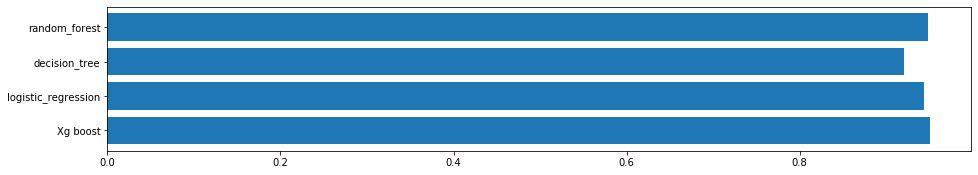

<Figure size 432x288 with 0 Axes>

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils
from pyspark import SparkContext, SparkConf
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark import SparkContext, SparkConf
import numpy as np
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
x_train, x_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)


spark = SparkSession.builder.appName('cruise').getOrCreate()

# Load and parse the data file into an RDD of LabeledPoint.
data = spark.read.csv('breast-cancer-wisconsin.csv', header = True, inferSchema = True)


from pyspark.ml.feature import VectorAssembler

assembler=VectorAssembler(inputCols=['clump_thickness','uniform_cell_size','uniform_cell_shape','marginal_adhesion','single_epi_cell_size','bland_chromation','normal_nucleoli','mitoses'],outputCol='features')
output=assembler.transform(data)
output.select('features','class').show(5)
#output as below
final_data=output.select('features','class')
#splitting data into train and test
train_data,test_data=final_data.randomSplit([0.7,0.3])
#train_data.describe().show()

rf = RandomForestClassifier(labelCol="class", featuresCol="features")
# Fit the model
rfModel = rf.fit(train_data)

dt = DecisionTreeClassifier(labelCol="class", featuresCol="features")
dtmodel = dt.fit(train_data)

lr = LogisticRegression(labelCol="class", featuresCol="features")

# Fit the model
lrModel = lr.fit(train_data)

# Make predictions.
predictions_rf = rfModel.transform(test_data)
predictions_dt = dtmodel.transform(test_data)
predictions_lr = lrModel.transform(test_data)

# Select example rows to display.
#predictions_rf.select("prediction", "class", "features").show(5)
#predictions_dt.select("prediction", "class", "features").show(5)
#predictions_lr.select("prediction", "class", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator_rf = MulticlassClassificationEvaluator(
    labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator_rf.evaluate(predictions_rf)
print ("Test Error = %g" % (1.0 - accuracy_rf))
print("randon forest" , accuracy_rf)

evaluator_dt = MulticlassClassificationEvaluator(
    labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy_dt = evaluator_dt.evaluate(predictions_dt)
print ("Test Error = %g" % (1.0 - accuracy_dt))
print("decision tree:" , accuracy_dt)


evaluator_lr = MulticlassClassificationEvaluator(
    labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy_lr = evaluator_lr.evaluate(predictions_lr)
print ("Test Error = %g" % (1.0 - accuracy_lr))
print("logistic regression:" , accuracy_lr)

import matplotlib.pyplot as plt

import xgboost as xgb
model=xgb.XGBClassifier()
model.fit(x_train, y_train)
accuracy_xgb = model.score(x_test, y_test)
print('XGBoost accuracy:',accuracy_xgb)
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([2,2,2,0.5])
models = ['random_forest', 'decision_tree', 'logistic_regression', 'Xg boost']
accuracy = [accuracy_rf, accuracy_dt, accuracy_lr, accuracy_xgb]
ax.barh(models,accuracy)
ax.invert_yaxis()
plt.show()
plt.savefig('models.png')







